In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import util
from test_to_bw_fast import read_model
import metrics
import wandb
from test_to_bw_fast import get_config
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from test_to_bw_fast import open_bw
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from tqdm import tqdm
from scipy.spatial import distance
from scipy import stats
import pickle, os


In [2]:
def filter_loss_df(filepath_path, bin_size, model, avg_cells=True):
    # filepath_path = whole_path
    raw_df = pd.read_csv(filepath_path)
    raw_df = raw_df[(raw_df['bin_size'] == bin_size) & (raw_df['model_fn']==model)]
    if avg_cells:
        mean_vals = raw_df.groupby('run_path')['mse', 'scaled mse', 'JS', 'poisson NLL', 'pearson r'].mean()
        df = mean_vals.merge(raw_df.iloc[:,6:].drop_duplicates(), on='run_path')
    else:
        df = raw_df
    log_dict = {'None':'raw ','True':'log '}
    df['loss'] = [log_dict[w] for w in df['log_loss'].values] + df['loss_fn'] 
    return df

In [3]:
summary_dir = 'summary_metrics_tables'
file_suffix_not_logged = 'LOSS_FUNCTION.csv'
file_suffix_logged = 'LOGGED_LOSS_FUNCTION.csv'
whole_path_logged = os.path.join(summary_dir, 'WHOLE_'+file_suffix_logged)
whole_path_not_logged = os.path.join(summary_dir, 'WHOLE_'+file_suffix_not_logged)

idr_path_not_logged = os.path.join(summary_dir, 'IDR_'+file_suffix_not_logged)
idr_path_logged = os.path.join(summary_dir, 'IDR_'+file_suffix_logged)

In [4]:
model_type = 'bpnet'
bin_size = 1
whole_df_logged = filter_loss_df(whole_path_logged, bin_size,model_type, True)
whole_df_not_logged = filter_loss_df(whole_path_not_logged, bin_size,model_type, True)
idr_df_logged = filter_loss_df(idr_path_logged, bin_size,model_type, True)
idr_df_not_logged = filter_loss_df(idr_path_not_logged, bin_size,model_type, True)

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [5]:
loss_fn = 'poisson'
for loss_fn in ['mse', 'poisson', 'basenjipearsonr', 'multinomialnll_mse_reg', 'pearsonr_mse']:
    not_logged_res = whole_df_not_logged[(whole_df_not_logged['loss'] == 'raw '+ loss_fn) ] 
    logged_res = whole_df_logged[(whole_df_logged['loss'] == 'raw '+ loss_fn) | (whole_df_logged['loss'] == 'log '+loss_fn)]

    not_logged_res['predictions'] = 'standard'
    logged_res['predictions'] = 'log'

    print(pd.concat([not_logged_res, logged_res]).pivot(index='loss', columns='predictions', values='pearson r'))
    print('---')

predictions       log  standard
loss                           
log mse      0.565258       NaN
raw mse      0.522071   0.54043
---
predictions       log  standard
loss                           
log poisson  0.563392       NaN
raw poisson  0.565389  0.593509
---
predictions               log  standard
loss                                   
log basenjipearsonr  0.587357       NaN
raw basenjipearsonr  0.323127  0.603702
---
predictions                      log  standard
loss                                          
log multinomialnll_mse_reg  0.565802       NaN
raw multinomialnll_mse_reg  0.518768  0.536044
---
predictions            log  standard
loss                                
log pearsonr_mse  0.573884       NaN
raw pearsonr_mse  0.539551  0.583892
---


/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [7]:
summary_dict = {}
df_labels = {whole_path_not_logged:'whole chromosome', idr_path_not_logged:'IDR'}
for df_path in [whole_path_not_logged, idr_path_not_logged]:
    summary_dict[df_labels[df_path]] = {}
    for bin_size in [1, 256]:
        summary_dict[df_labels[df_path]][bin_size] = []
        for model_type in ['bpnet', 'basenjiw1', 'basenjimod']:
            df = filter_loss_df(df_path, bin_size,model_type, False)
            df = df[df['log_loss'] == 'None']
            df = df[['model_fn', 'loss_fn', 'pearson r', 'mse', 'scaled mse', 'JS', 'poisson NLL']]
            summary_dict[df_labels[df_path]][bin_size].append(df)

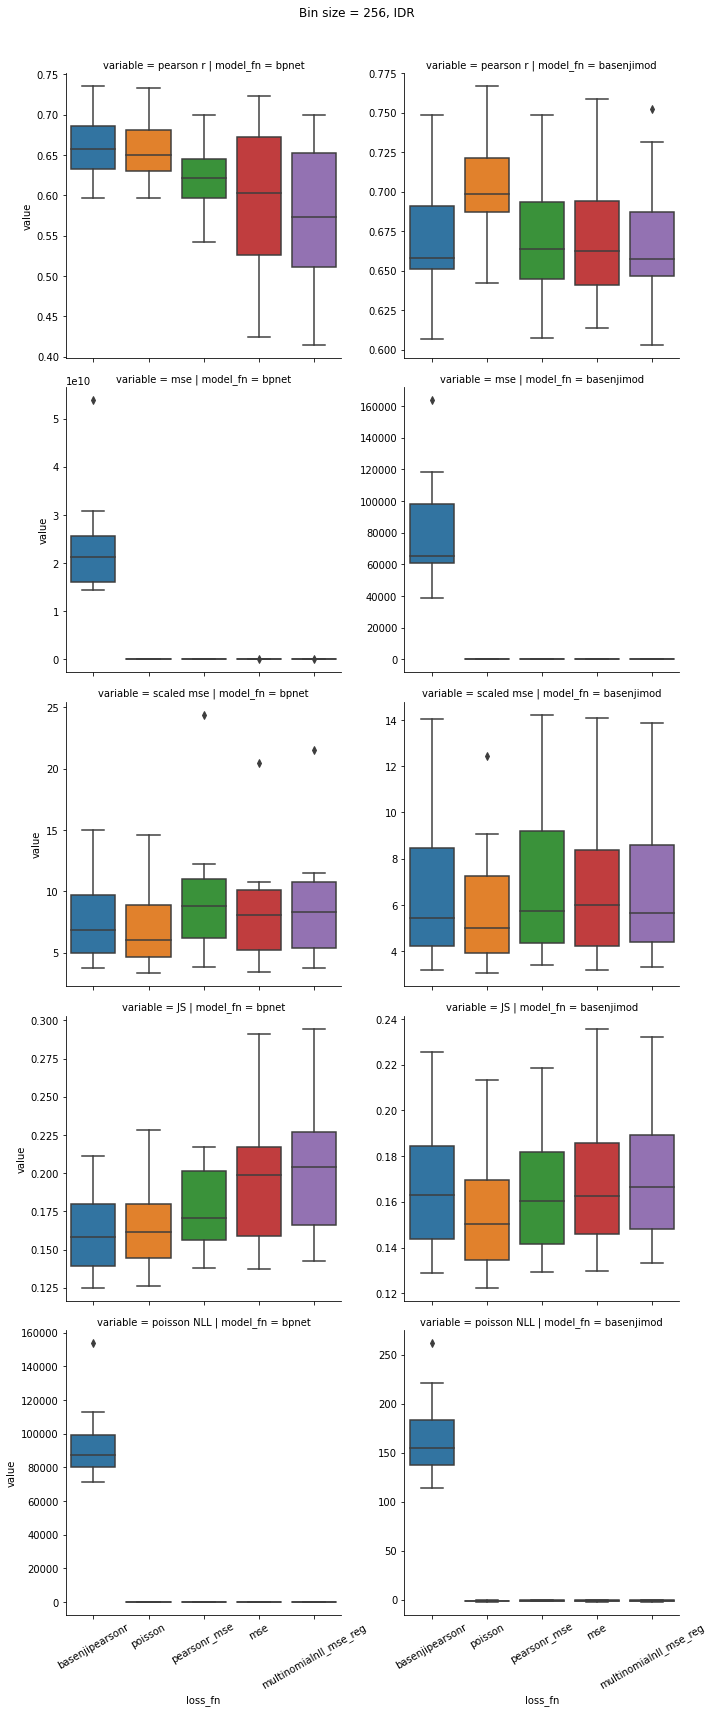

In [8]:
bin_size = 256
test_set_type = 'IDR'
df = pd.concat(summary_dict[test_set_type][bin_size]).melt(['model_fn', 'loss_fn'])
# df = df[df['loss_fn'] != 'basenjipearsonr']

g = sns.catplot(data=df, x='loss_fn', y='value', kind='box', col='model_fn', row='variable', sharey=False,
           order=['basenjipearsonr', 'poisson', 'pearsonr_mse', 'mse', 'multinomialnll_mse_reg'])
g.set_xticklabels(rotation=30)
plt.suptitle('Bin size = {}, {}'.format(bin_size, test_set_type))
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

In [9]:
bin_size = 256
test_set_type = 'IDR'
df = pd.concat(summary_dict[test_set_type][bin_size])
df=df.rename(columns = {'model_fn':'model', 'loss_fn':'loss','scaled mse':'scaled MSE', 'mse':'MSE'})
loss_dict = {'basenjipearsonr':'pearson r', 'mse':'MSE', 
             'multinomialnll_mse_reg':'multinomial NLL + \nMSE', 'pearsonr_mse':'pearson r + MSE',
             'poisson': 'poisson NLL'
            }
model_dict = {'bpnet':'BPNet', 'basenjimod':'Basenji', 'basenjiw1':'Basenji base res'}
df['model'] = [model_dict[l] for l in df['model'].values]


df['loss'] = [loss_dict[l] for l in df['loss'].values]

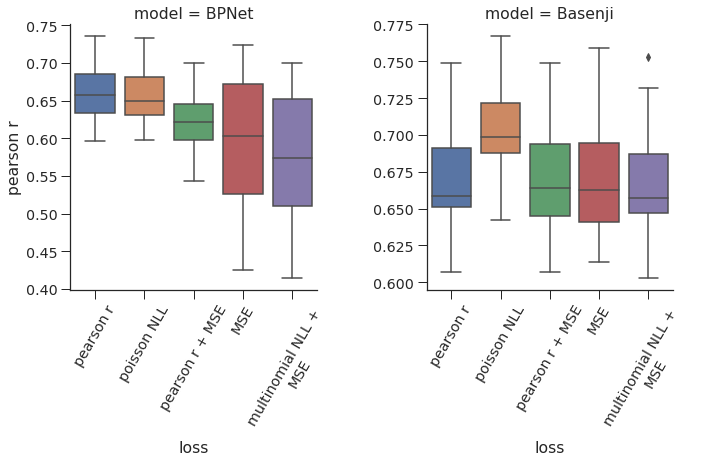

In [10]:

# df = pd.concat(summary_dict[test_set_type][bin_size]).melt(['model_fn', 'loss_fn'])
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


metric1 = 'pearson r'
g = sns.catplot(data=df, x='loss', y=metric1, kind='box', col='model', sharey=False,
           order=['pearson r', 'poisson NLL', 'pearson r + MSE', 'MSE', 'multinomial NLL + \nMSE']
               )
g.set_xticklabels(rotation=60)
# plt.suptitle('Bin size = {}, {}'.format(bin_size, test_set_type))
# plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('plots/loss_{}.svg'.format(metric1.replace(' ', '_')), bbox_inches='tight')

In [70]:
summary_dir = 'summary_metrics_tables'
file_suffix_not_logged = 'LOSS_FUNCTION.csv'
whole_path_not_logged = os.path.join(summary_dir, 'WHOLE_'+file_suffix_not_logged)

idr_path_not_logged = os.path.join(summary_dir, 'IDR_'+file_suffix_not_logged)


In [71]:
def avg_df(filepath_path, avg_cells=True):
    # filepath_path = whole_path
    raw_df = pd.read_csv(filepath_path)


    if avg_cells:
        mean_vals = raw_df.groupby('run_path')['mse', 'scaled mse', 'JS', 'poisson NLL', 'pearson r'].mean()
        df = mean_vals.merge(raw_df.iloc[:,6:].drop_duplicates(), on='run_path')
    else:
        df = raw_df
    log_dict = {'None':'raw ','True':'log '}

    return df

In [122]:
loss_df = avg_df(whole_path_not_logged)
loss_fns = []
for run in loss_df['run_path']:
    config = get_config(run)
    if 'log_loss' in config.keys():
        if config['log_loss']['value'] == True:
            loss_fns.append('REMOVE')
        else:
            loss_fns.append(config['loss_fn']['value'])
    else:
        loss_fns.append(config['loss_fn']['value'])
loss_df['loss_fn'] = loss_fns

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [123]:
loss_df = loss_df[loss_df['loss_fn']!='REMOVE'].reset_index()

In [124]:
piv_loss_df = loss_df[['bin_size', 'loss_fn', 'pearson r']].pivot(index='loss_fn', columns='bin_size',
                                                   values='pearson r').reset_index()

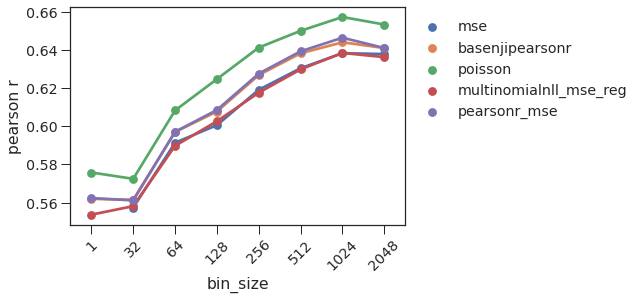

In [125]:
sns.pointplot(data=loss_df, x='bin_size', y='pearson r', hue='loss_fn')
plt.xticks(rotation=45);
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [126]:
piv_loss_df.set_index('loss_fn', inplace=True)

<AxesSubplot:xlabel='bin_size', ylabel='loss_fn'>

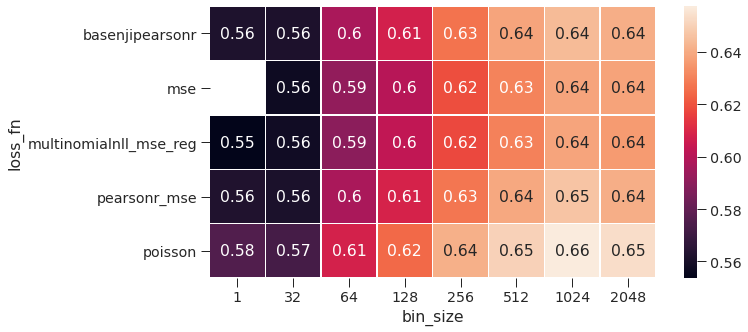

In [127]:
plt.figure(figsize=[10,5])
sns.heatmap(piv_loss_df, annot=True, linewidths=.5)

,index,run_path,mse,scaled mse,JS,poisson NLL,pearson r,model_fn,bin_size,data_dir,loss_fn
10,20,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,1473.601672,0.694926,0.324016,23.957864,0.561462,basenjimod,32,datasets/complete/random_chop/i_3072_w_1/,basenjipearsonr
11,21,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.698798,0.696118,0.323780,0.813110,0.558130,basenjimod,32,datasets/complete/random_chop/i_3072_w_1/,multinomialnll_mse_reg
12,22,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.700005,0.698510,0.324020,0.813002,0.557365,basenjimod,32,datasets/complete/random_chop/i_3072_w_1/,mse
13,23,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.685711,0.683574,0.321198,0.809492,0.572477,basenjimod,32,datasets/complete/random_chop/i_3072_w_1/,poisson
19,29,/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shus...,0.749347,0.702596,0.325422,0.824874,0.561142,basenjimod,32,datasets/complete/random_chop/i_3072_w_1/,pearsonr_mse


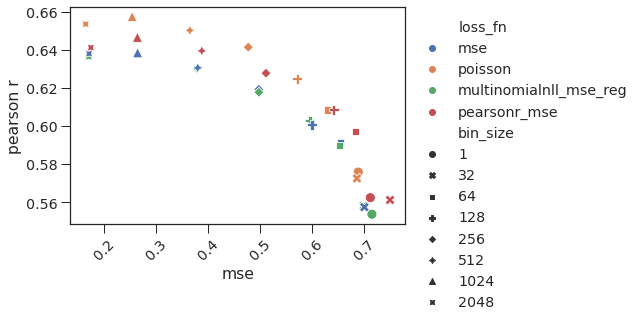

In [147]:
sns.scatterplot(data=loss_df[loss_df['loss_fn']!='basenjipearsonr'], 
                x='mse', y='pearson r', hue='loss_fn', style='bin_size', s=100)
plt.xticks(rotation=45);
plt.legend(frameon=False, bbox_to_anchor=(1,1))

# new finetune bin loss experiment

In [6]:
summary_performance = pd.concat([pd.read_csv('summary_metrics_tables/BASENJI_BIN_LOSS.csv'), pd.read_csv('summary_metrics_tables/BASENJI_BIN_LOSS_256.csv')
])


In [7]:
average_summary_performance = summary_performance[(summary_performance['pred type'] == 'raw')&
                                                  (summary_performance['eval type'] == 'whole')
                                                  ].groupby(['bin_size', 'loss_fn']).mean().reset_index()

In [14]:
loss_name_subs = {'basenjipearsonr': 'pearson r', 'mse': 'MSE',
                  'multinomialnll_mse_reg':'multinomial NLL + MSE',
                 'poisson':'poisson NLL', 'pearsonr_mse': 'pearson r + MSE'}

average_summary_performance['loss'] = [loss_name_subs[l] for l in average_summary_performance['loss_fn'].values]

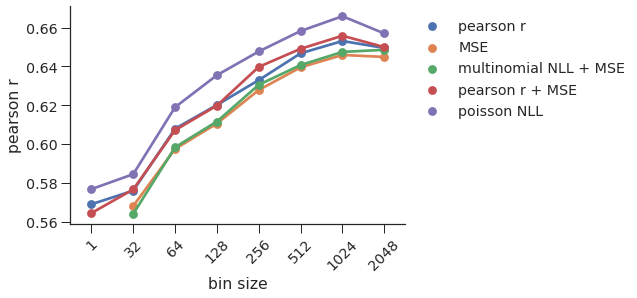

In [20]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.pointplot(data=average_summary_performance, x='bin_size', y='pr', hue='loss')
plt.xticks(rotation=45);
plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('bin size')
plt.ylabel('pearson r')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.tight_layout()
plt.savefig('plots/bin_loss_basenji.svg', bbox_inches="tight")